In [2]:
import numpy as np
import pandas as pd

In [3]:
data = pd.read_csv("train.csv")

# EDA

In [4]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
data.shape

(7613, 5)

## Initial cleanup

### Handling NaNs

In [6]:
def na_counts(df):
    na_columns = df.columns[df.isna().any()]
    if len(na_columns)==0:
        return 0
    return df[na_columns].isna().apply(lambda x: x.value_counts())

In [7]:
na_counts(data)

,keyword,location
False,7552,5080
True,61,2533


In [8]:
na_counts(data)

,keyword,location
False,7552,5080
True,61,2533


In [9]:
data = data.fillna("")

In [10]:
na_counts(data)

0

## Exploring variables

In [132]:
from sklearn.metrics import mutual_info_score
from sklearn.metrics import f1_score
from sklearn.feature_extraction import DictVectorizer

In [12]:
def sorted_corr_coefs(df, column_name, target_column_name):
    dv = DictVectorizer(sparse=False)
    dict = data[[column_name]].to_dict(orient='records')
    columns = np.transpose(dv.fit_transform(dict))
    corrcoefs = []
    for col in columns:
        corrcoefs.append(np.corrcoef(col, data[target_column_name])[0, 1])
    named_list = list(zip(dv.get_feature_names_out(), corrcoefs))
    named_list.sort(key=lambda tup: tup[1], reverse = True)
    return named_list

In [13]:
# Analyzing mutual info score I want to compare it with such of a shuffled data
shuffled_target = data.target.sample(frac=1, random_state=10)

### Variable "keyword"

In [14]:
data.keyword.value_counts()

                         61
fatalities               45
deluge                   42
armageddon               42
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 222, dtype: int64

In [15]:
mutual_info_score(data['keyword'], data['target']), mutual_info_score(data['keyword'], shuffled_target)

(0.16947295623391556, 0.013396592412637555)

In [16]:
sorted_corr_coefs(data, "keyword", "target")[:30], sorted_corr_coefs(data, "keyword", "target")[-30:]

([('keyword=derailment', 0.08267501656791963),
  ('keyword=wreckage', 0.08267501656791963),
  ('keyword=debris', 0.080516616503906),
  ('keyword=outbreak', 0.08006342865745676),
  ('keyword=typhoon', 0.07783761510564755),
  ('keyword=oil%20spill', 0.0778376151056471),
  ('keyword=suicide%20bombing', 0.07198080078232648),
  ('keyword=suicide%20bomber', 0.0695037416094893),
  ('keyword=suicide%20bomb', 0.06653252563655127),
  ('keyword=rescuers', 0.06653252563655115),
  ('keyword=nuclear%20disaster', 0.06522974951590454),
  ('keyword=evacuated', 0.06394441989331812),
  ('keyword=bombing', 0.06263006921820151),
  ('keyword=razed', 0.06261005839265929),
  ('keyword=wildfire', 0.05986365507855725),
  ('keyword=airplane%20accident', 0.058687591148766684),
  ('keyword=wild%20fires', 0.057003478164473),
  ('keyword=buildings%20on%20fire', 0.05582460651063401),
  ('keyword=mass%20murder', 0.055824606510633965),
  ('keyword=bridge%20collapse', 0.05476512390487407),
  ('keyword=forest%20fires', 0

### Variable "location"

In [17]:
data.location.value_counts()

                                2533
USA                              104
New York                          71
United States                     50
London                            45
                                ... 
Surulere Lagos,Home Of Swagg       1
MontrÌ©al, QuÌ©bec                 1
Montreal                           1
ÌÏT: 6.4682,3.18287                1
Lincoln                            1
Name: location, Length: 3342, dtype: int64

In [18]:
mutual_info_score(data['location'], data['target']), mutual_info_score(data['location'], shuffled_target)

(0.31254635681695697, 0.30151620936968093)

In [19]:
sorted_corr_coefs(data, "location", "target")[:10], sorted_corr_coefs(data, "location", "target")[-10:]

([('location=USA', 0.05101140011993961),
  ('location=Mumbai', 0.047195302822488135),
  ('location=India', 0.045857912019408635),
  ('location=Nigeria', 0.043700694813182915),
  ('location=Washington, DC', 0.030239642046364305),
  ('location=Bend, Oregon', 0.026416230235620966),
  ('location=Nairobi-KENYA', 0.02641623023562073),
  ('location=Calgary', 0.026416230235620723),
  ('location=Nigeria ', 0.02641623023562072),
  ('location=Portland, Oregon', 0.02641623023562072)],
 [('location=Coventry', -0.022250773490737206),
  ('location=Texas, USA', -0.02225077349073725),
  ('location=Indiana', -0.02225077349073729),
  ('location=Wisconsin', -0.02225077349073729),
  ('location=ss', -0.024151501376051914),
  ('location=London, England', -0.024151501376051928),
  ('location=Morioh, Japan', -0.024376103182953163),
  ('location=Pennsylvania, USA', -0.026330931421991832),
  ('location=304', -0.029860396014459598),
  ('location=New York', -0.04004435015466763)])

### Variable "text"

In [22]:
from sklearn import feature_extraction, linear_model, model_selection, preprocessing

##### Count vectorizer does similar thing to usual dict vectorizer. It splits texts into separate words and create a column for each word. Than it assigns a number of occurences for each word in each cell of a particular column. In our case it will be `text`

In [23]:
count_vectorizer = feature_extraction.text.CountVectorizer()
vectors = count_vectorizer.fit_transform(data['text'])
vectors.shape

(7613, 21637)

##### Let's see how the first text look like in terms of words frequencies

In [24]:
frequencies = list(zip(count_vectorizer.get_feature_names_out(), vectors[0].todense().getA()[0]))
[x for x in frequencies if x[1] > 0], data.text[0]

([('all', 1),
  ('allah', 1),
  ('are', 1),
  ('deeds', 1),
  ('earthquake', 1),
  ('forgive', 1),
  ('may', 1),
  ('of', 1),
  ('our', 1),
  ('reason', 1),
  ('the', 1),
  ('this', 1),
  ('us', 1)],
 'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all')

##### Interesting! There are hashtags, i.e. #earthquake, but they are extracted as simple words. Let's fix this

In [25]:
hashtag_pattern = r'(?u)\b\w\w+\b|#?\w\w+\b'
count_vectorizer = feature_extraction.text.CountVectorizer(token_pattern=hashtag_pattern)
vectors = count_vectorizer.fit_transform(data['text'])
vectors.shape

(7613, 22351)

In [26]:
frequencies = list(zip(count_vectorizer.get_feature_names_out(), vectors[0].todense().getA()[0]))
[x for x in frequencies if x[1] > 0], data.text[0]

([('#earthquake', 1),
  ('all', 1),
  ('allah', 1),
  ('are', 1),
  ('deeds', 1),
  ('forgive', 1),
  ('may', 1),
  ('of', 1),
  ('our', 1),
  ('reason', 1),
  ('the', 1),
  ('this', 1),
  ('us', 1)],
 'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all')

##### Now let's just have a look at random keywords from the top of the list:

In [27]:
count_vectorizer.get_feature_names_out()[0:100]

array(['#0215', '#034', '#039', '#06', '#09', '#1008pla', '#1008planet',
       '#124', '#140', '#16', '#163', '#17', '#171', '#2015', '#20150613',
       '#22days', '#24', '#263chat', '#2a', '#2fast2furious',
       '#2minutemix', '#360wisenews', '#365disasters', '#37592', '#38745',
       '#3novices', '#452', '#4playthursdays', '#5sosfam', '#615', '#629',
       '#7newsadl', '#8217', '#8392', '#89x', '#911', '#9973', '#999day',
       '#9newsmornings', '#abandoned', '#abbott', '#abc',
       '#abc7eyewitness', '#abcnews', '#abha', '#ableg', '#abomb',
       '#abstorm', '#accident', '#accidentalprophecy', '#acenewsdesk',
       '#achedin', '#act', '#actionmoviestaughtus', '#adani',
       '#addtexastonext1dtour', '#adiossuperbacterias', '#adjust',
       '#adult', '#aeroplane', '#aerospace', '#afc', '#afghanistan',
       '#afp', '#africa', '#africanbaze', '#africansinsf', '#after',
       '#afterhaiyan', '#afterlife', '#aftershock', '#age', '#aids',
       '#aintsheperty', '#aircraft

##### A lot or weird texts looking like some hashes or something. Let's find where one of them occur in the texts

In [28]:
data.loc[data['text'].str.contains("0cxm5tkz8y", case=False)].text.values[0]

'Sharp rise in women children casualties in Afghan war UN says http://t.co/0CXm5TkZ8y http://t.co/v5aMDOvHOT'

##### So these look like parts of urls. Let's check how many different urls we have

In [29]:
url_pattern =  r'(https?:\/\/(?:www\.)?[-a-zA-Z0-9@:%._+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}[-a-zA-Z0-9()@:%_+.~#?&/=]*)'

In [30]:
data.text[data.text.str.findall(url_pattern).apply(len) > 0].values

array(['@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C',
       'We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw',
       '#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi',
       ...,
       'Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5',
       'M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ',
       'The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d'],
      dtype=object)

In [31]:
data.text.str.findall(url_pattern).apply(lambda x: x[0] if len(x) > 0 else None).value_counts()

http://t.co/qew4c5M1xd    9
http://t.co/KSAwlYuX02    6
http://t.co/q2eBlOKeVE    6
http://t.co/vVPLFQv58P    5
http://t.co/cybKsXHF7d    5
                         ..
http://t.co/NXLEiIJFgS    1
http://t.co/y5Yhbb0hkf    1
http://t.co/GedOxSPpL9    1
http://t.co/4k8OLZv9bV    1
http://t.co/YmY4rSkQ3d    1
Name: text, Length: 3875, dtype: int64

##### Probably some of them might be a good indicator of a target. We might want to create a separate column, such as number of urls in a text or something like that

##### Let's observe correlation of different words with target

In [32]:
columns = np.transpose(vectors.todense().A)
columns.shape

(22351, 7613)

In [33]:
corrcoefs = []
for col in columns:
    corrcoefs.append(np.corrcoef(col, data.target)[0, 1])
named_list = list(zip(count_vectorizer.get_feature_names_out(), corrcoefs))
named_list.sort(key=lambda tup: tup[1], reverse = True)

In [34]:
named_list[0:10], named_list[-10:]

([('http', 0.2126857016032362),
  ('co', 0.19572817733727796),
  ('in', 0.1651045693565625),
  ('california', 0.12913544724422837),
  ('suicide', 0.12401359099263466),
  ('killed', 0.11853259856300873),
  ('mh370', 0.10691665675635052),
  ('northern', 0.10608400609185162),
  ('hiroshima', 0.10465394740838699),
  ('after', 0.10165252947420254)],
 [('love', -0.06875973302225376),
  ('can', -0.07132110403337122),
  ('it', -0.07247470509376949),
  ('full', -0.0730178581511043),
  ('so', -0.07517673569508387),
  ('your', -0.07672163676999283),
  ('body', -0.08303134852414512),
  ('me', -0.08871342288840284),
  ('my', -0.12872670360280616),
  ('you', -0.15300123086640835)])

In [35]:
tags_list = list(filter(lambda tup: "#" in tup[0], named_list))
tags_list[:10], tags_list[-10:]

([('#hiroshima', 0.062024958475825245),
  ('#news', 0.059967246136529775),
  ('#earthquake', 0.0576296711740032),
  ('#japan', 0.04382652606782275),
  ('#yyc', 0.04178420487501189),
  ('#india', 0.04178420487501188),
  ('#breaking', 0.03963737068015414),
  ('#worldnews', 0.039637370680154126),
  ('#abstorm', 0.03963737068015392),
  ('#disaster', 0.03736801441379245)],
 [('#ices', -0.026330931421991874),
  ('#trapmusic', -0.026330931421991874),
  ('#animalrescue', -0.02633093142199191),
  ('#edm', -0.028150800356406054),
  ('#dnb', -0.02815080035640607),
  ('#beyhive', -0.02815080035640608),
  ('#fashion', -0.029860396014459552),
  ('#job', -0.0344866190142626),
  ('#nowplaying', -0.03654880702029747),
  ('#jobs', -0.037254707512115647)])

In [36]:
freq_sums = vectors.todense().sum(axis=0).A[0]

In [37]:
named_sums = list(zip(count_vectorizer.get_feature_names_out(), freq_sums))
named_sums = list(filter(lambda tup: tup[1] > 5, named_sums))
print (len(named_sums))
sorted(named_sums, key=lambda tup: tup[1], reverse=True)[0:30]

2399


[('co', 4739),
 ('http', 4309),
 ('the', 3277),
 ('in', 1985),
 ('to', 1949),
 ('of', 1830),
 ('and', 1426),
 ('is', 949),
 ('you', 902),
 ('for', 894),
 ('on', 860),
 ('it', 779),
 ('my', 680),
 ('that', 623),
 ('with', 572),
 ('at', 542),
 ('by', 527),
 ('this', 480),
 ('from', 422),
 ('https', 411),
 ('be', 408),
 ('are', 404),
 ('have', 386),
 ('was', 386),
 ('like', 348),
 ('û_', 348),
 ('amp', 344),
 ('as', 331),
 ('up', 330),
 ('me', 329)]

# Training Models

In [38]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import scipy.sparse as sp
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.feature_selection import SelectKBest, chi2

In [39]:
df_full_train, df_test = train_test_split(data, test_size=0.2, random_state=42)
df_full_train.shape, df_test.shape

((6090, 5), (1523, 5))

In [58]:
min_df = 3
train_c_vectorizer = CountVectorizer(min_df=min_df)
train_c_2ng_vectorizer = CountVectorizer(ngram_range=(1,2), min_df=min_df)
train_c_3ng_vectorizer = CountVectorizer(ngram_range=(1,3), min_df=min_df)
train_kw_d_vectorizer = DictVectorizer()
train_loc_d_vectorizer = DictVectorizer()

train_kw_dict = df_full_train[['keyword']].to_dict(orient='records')
train_loc_dict = df_full_train[['location']].to_dict(orient='records')

train_kw_vectors = train_kw_d_vectorizer.fit_transform(train_kw_dict)
train_loc_vectors = train_loc_d_vectorizer.fit_transform(train_loc_dict)
train_text_vectors = train_c_vectorizer.fit_transform(df_full_train.text)
train_text_2ng_vectors = train_c_2ng_vectorizer.fit_transform(df_full_train.text)
train_text_3ng_vectors = train_c_3ng_vectorizer.fit_transform(df_full_train.text)

best_3ng_kw_loc_vectors = SelectKBest(chi2, k=10000).fit_transform(sp.hstack((train_text_3ng_vectors, train_kw_vectors, train_loc_vectors)), df_full_train.target)

train_vectors_combinations = {
    'text': train_text_vectors,
    'text_kw': sp.hstack((train_text_vectors, train_kw_vectors)),
    'text_loc': sp.hstack((train_text_vectors, train_loc_vectors)),
    'text_kw_loc': sp.hstack((train_text_vectors, train_kw_vectors, train_loc_vectors)),
    'text_2ng_kw_loc': sp.hstack((train_text_2ng_vectors, train_kw_vectors, train_loc_vectors)),
}

train_text_2ng_vectors.shape

(6090, 8028)

In [60]:
train_text_poly_best = PolynomialFeatures(2).fit_transform(train_vectors_combinations['text_kw_loc'])
train_vectors_combinations['text_poly_kw_loc_best_1600'] = SelectKBest(chi2, k=1600).fit_transform(train_text_poly_best, df_full_train.target)

In [61]:
train_text_poly_best = PolynomialFeatures(2).fit_transform(train_vectors_combinations['text_kw_loc'])
train_vectors_combinations['text_poly_kw_loc_best_10000'] = SelectKBest(chi2, k=10000).fit_transform(train_text_poly_best, df_full_train.target)

In [62]:
train_text_poly_best = PolynomialFeatures(2).fit_transform(train_vectors_combinations['text_kw_loc'])
train_vectors_combinations['text_poly_kw_loc_best_20000'] = SelectKBest(chi2, k=20000).fit_transform(train_text_poly_best, df_full_train.target)

In [59]:
train_text_poly_best = PolynomialFeatures(2).fit_transform(train_vectors_combinations['text_2ng_kw_loc'])
train_vectors_combinations['text_poly_2ng_kw_loc_best_20000'] = SelectKBest(chi2, k=20000).fit_transform(train_text_poly_best, df_full_train.target)

### Comparing Ridge Classifier and Logistic Regression

In [63]:
model_rc = RidgeClassifier(random_state=42, max_iter=500, class_weight="balanced")
model_lr = LogisticRegression(solver="liblinear", C=1.0, max_iter=500, random_state=42)

cv = model_selection.StratifiedKFold(4, shuffle=True, random_state=55)  

df = pd.DataFrame()
for key, vectors in train_vectors_combinations.items():
    scores_rc = model_selection.cross_val_score(model_rc, vectors, df_full_train["target"], cv=cv, scoring="f1")
    scores_lr = model_selection.cross_val_score(model_lr, vectors, df_full_train["target"], cv=cv, scoring="f1")
    df = pd.concat([df, pd.DataFrame([{
        'Features': key,
        'Ridge Classifier': scores_rc.mean(),
        'Logistic Regression': scores_lr.mean()
    }])])
df

,Features,Ridge Classifier,Logistic Regression
0,text,0.706225,0.748731
0,text_kw,0.708066,0.752726
0,text_loc,0.710795,0.744532
0,text_kw_loc,0.709522,0.749563
0,text_2ng_kw_loc,0.710809,0.743843
0,text_poly_2ng_kw_loc_best_20000,0.695960,0.759453
0,text_poly_kw_loc_best_1600,0.699946,0.705086
0,text_poly_kw_loc_best_10000,0.701522,0.762588
0,text_poly_kw_loc_best_20000,0.720695,0.776113


Some observations:
- adding the `keywords` feature slightly improves the score, while adding `location` feature tents to reduce it, which accords with our `mutual_info_score` findings.
- adding 2- and 3-ngrams reduces the score
- the best result is shown with combination of `text` and `keyword` features and Logistic Regression model

In [66]:
# (train_vectors_combinations['text_kw_loc'].shape[1], 
# train_vectors_combinations['text_2ng_kw_loc'].shape[1], 
# train_vectors_combinations['text_3ng_kw_loc'].shape[1])

The dimensionality is too high for more sophisticated methods. Also it can happen that our columns contain some words that actually reduce the score

TruncatedSVD is a way to reduce number of features in sparse matrices. Putting it simply it retains n_components of most important features.

In [67]:
from functools import reduce
list(train_vectors_combinations.values())

[<6090x3791 sparse matrix of type '<class 'numpy.int64'>'
 	with 72633 stored elements in Compressed Sparse Row format>,
 <6090x4013 sparse matrix of type '<class 'numpy.float64'>'
 	with 78723 stored elements in Compressed Sparse Row format>,
 <6090x6563 sparse matrix of type '<class 'numpy.float64'>'
 	with 78723 stored elements in Compressed Sparse Row format>,
 <6090x6785 sparse matrix of type '<class 'numpy.float64'>'
 	with 84813 stored elements in Compressed Sparse Row format>,
 <6090x11022 sparse matrix of type '<class 'numpy.float64'>'
 	with 114718 stored elements in Compressed Sparse Row format>,
 <6090x20000 sparse matrix of type '<class 'numpy.float64'>'
 	with 358303 stored elements in Compressed Sparse Row format>,
 <6090x1600 sparse matrix of type '<class 'numpy.float64'>'
 	with 92566 stored elements in Compressed Sparse Row format>,
 <6090x10000 sparse matrix of type '<class 'numpy.float64'>'
 	with 220079 stored elements in Compressed Sparse Row format>,
 <6090x20000

In [69]:
from sklearn.decomposition import TruncatedSVD
from IPython.display import clear_output

def truncated_vectors(features, components_range, n_iter=20):
    n_work = sum([train_vectors_combinations[k].shape[1] for k in features])
    c_work = sum(coarse_components_range)    
    total_work = n_work*c_work
    done_work = 0
    
    result = {}
    for f in features:
        dict = {}
        for n in components_range:
            clear_output(wait=True)
            done_percentage = round(100*done_work/total_work)
            print(f"{done_percentage}% completed")
            iter_work = n*train_vectors_combinations[f].shape[1]
            iter_percentage = round(100*iter_work/total_work)
            print (f"Processing {n} components in {f} ({iter_percentage}%)")
            svd = TruncatedSVD(n_components=n, n_iter=20, random_state=42)
            vectors = svd.fit_transform(train_vectors_combinations[f])
            dict[n] = vectors
            done_work+=iter_work
        result[f] = dict
    return result

In [71]:
coarse_components_range = range(50, 1251, 300)
coarse_features = ['text', 
                   'text_kw',
                   'text_kw_loc', 
                   'text_2ng_kw_loc', 
                   'text_poly_kw_loc_best_1600', 
                   'text_poly_kw_loc_best_10000', 
                   'text_poly_kw_loc_best_20000', 
                   'text_poly_2ng_kw_loc_best_20000']
coarse_truncated_vectors = truncated_vectors(coarse_features, coarse_components_range)

90% completed
Processing 1250 components in text_poly_2ng_kw_loc_best_20000 (10%)


In [157]:
import time
from datetime import timedelta

In [73]:
def calculate_scores(truncated_vectors, models, random_state=42, additional_vectors=None):
    scores_dicts = []
    
    cv = model_selection.StratifiedKFold(4, shuffle=True, random_state=42)

    total_work = sum([len(dict) for dict in truncated_vectors.values()]) * len(models)
    done_work = 0
    start_time = time.time()
    
    for f, dict in truncated_vectors.items():
        for model_name, model in models.items():
            model_scores = []
            comp_range = dict.keys()
            for n in comp_range:
                clear_output(wait=True)
                done_ratio = done_work/total_work
                done_percentage = round(100*done_ratio)
                time_passed = time.time() - start_time
                time_left = "Unknown" if done_work==0 else timedelta(seconds=round((1-done_ratio)*time_passed/done_ratio))
                print(f"{done_percentage}% completed. Time passed: {round(time_passed)}. Time left: {time_left}")
                vectors = dict[n]
                if additional_vectors is not None:
                    vectors = sp.hstack((vectors, additional_vectors))                
                print(f"{f} {model_name} {n} components")
                model_scores.append(model_selection.cross_val_score(model, vectors, df_full_train["target"], cv=cv, scoring="f1").mean())    
                done_work += 1
            scores_dicts.append({
                'feature': f,
                'model': model_name,
                'comp_range': comp_range,
                'scores': model_scores
            })
    print ("Done")
    return scores_dicts

In [74]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

tree_model = DecisionTreeClassifier(max_depth=7)
forest_model = RandomForestClassifier(n_estimators=50,
                            max_depth=7,
                            min_samples_leaf=2,
                            random_state=42)
xgb_model = XGBClassifier(learning_rate=0.2,
                          n_estimators=50, 
                          max_depth=7, 
                          min_child_weight=1, 
                          objective="binary:logistic", 
                          seed=42)

models = {
    'Ridge Classifier': model_rc,
    'Logistic Regression': model_lr,
    'Tree': tree_model,
    'Random Forest': forest_model,
    'XGBoost': xgb_model
}

In [ ]:
%%time
scores_dicts = calculate_scores(coarse_truncated_vectors, models)

100% completed. Time passed: 1492. Time left: 0:00:07
text_poly_2ng_kw_loc_best_20000 XGBoost 1250 components


In [77]:
def plot_scores(scores, canvas=plt):
    for dict in scores:
        canvas.plot(dict['comp_range'], dict['scores'], label=f"{dict['model']} {dict['feature']}")
        canvas.ylabel("f1 score")
        canvas.xlabel("n_components")
    canvas.legend()

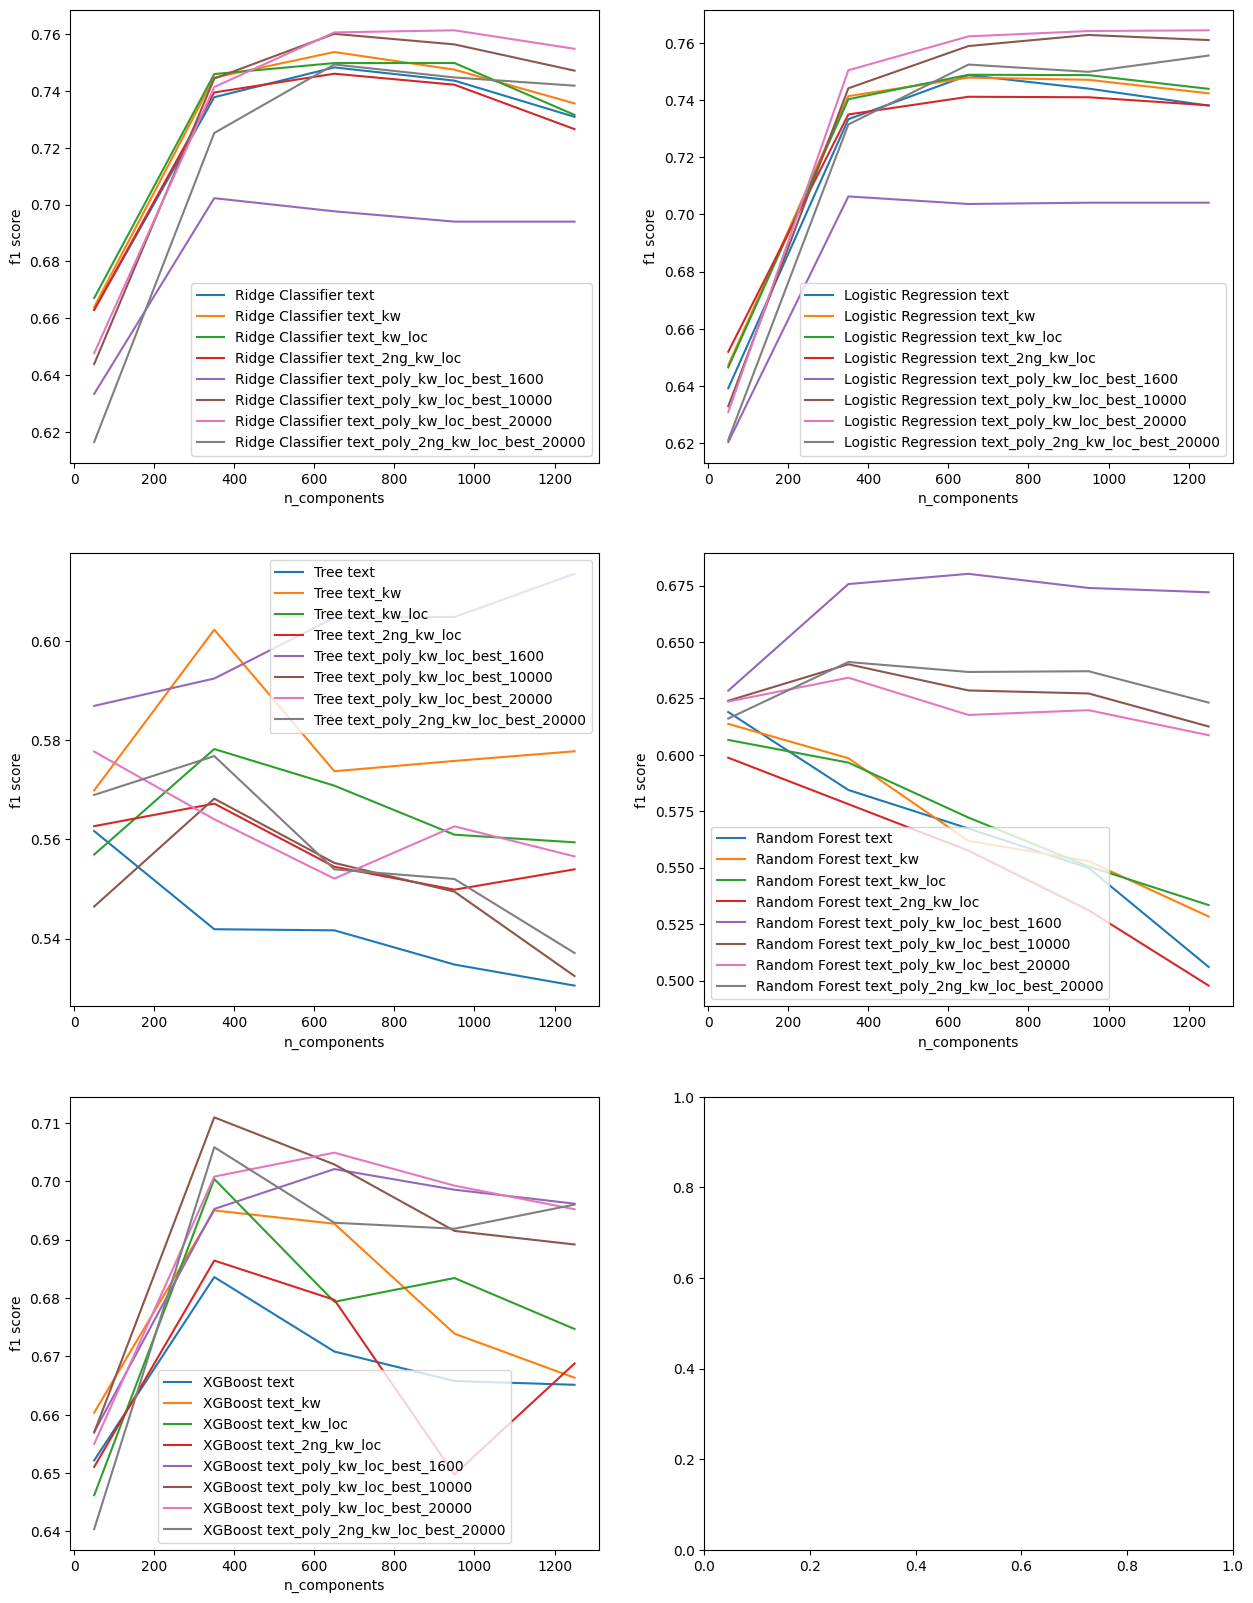

In [78]:
fig, ax = plt.subplots(3, 2, figsize=(15,20))
i = 1
for model_name in models:
    plt.subplot(3, 2, i) 
    plot_scores([d for d in scores_dicts if d['model'] == model_name])
    i+=1

The most interesting results are shown by Ridge Classifier and Logistic Regression on range 400-800 on the set text_poly_kw_loc_best_10000. Let's zoom in

In [81]:
fine_components_range = range(400, 801, 50)
fine_features = ['text_poly_kw_loc_best_20000']
fine_truncated_vectors = truncated_vectors(fine_features, fine_components_range)

142% completed
Processing 800 components in text_poly_kw_loc_best_20000 (25%)


In [82]:
%%time
fine_models = {    
    'Ridge Classifier': model_rc,
    'Logistic Regression': model_lr
}

fine_scores_dicts = calculate_scores(fine_truncated_vectors, fine_models)

94% completed. Time passed: 44. Time left: 0:00:03
text_poly_kw_loc_best_20000 Logistic Regression 800 components
Done
CPU times: user 48.3 s, sys: 49.9 s, total: 1min 38s
Wall time: 51.5 s


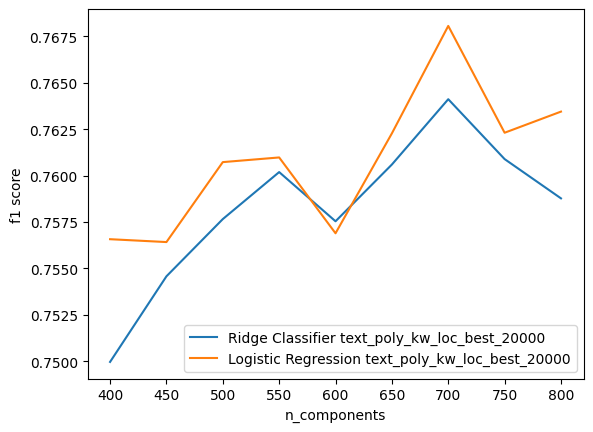

In [83]:
# fig, ax = plt.subplots(3, 2, figsize=(15,20))
# i = 1
for model_name in fine_models:
    # plt.subplot(3, 2, i) 
    plot_scores([d for d in fine_scores_dicts if d['model'] == model_name])
    # i+=1

In [84]:
hashtag_pattern = r'(?u)#\w+\b'

df_additional = pd.DataFrame()
df_additional['text_len'] = df_full_train.text.str.len()
df_additional['keyword_in_text'] = df_full_train.apply(lambda x: x.keyword.lower() in x.text.lower(), axis=1).astype(int)
df_additional['location_in_text'] = df_full_train.apply(lambda x: x.location.lower() in x.text.lower(), axis=1).astype(int)
df_additional['url_count'] = df_full_train.text.str.count(url_pattern)
df_additional['hashtag_count'] = df_full_train.text.str.count(hashtag_pattern)
df_additional['target'] = df_full_train['target']

df_additional.corr()

,text_len,keyword_in_text,location_in_text,url_count,hashtag_count,target
text_len,1.000000,-0.038747,-0.048554,0.300063,0.211123,0.179213
keyword_in_text,-0.038747,1.000000,0.025828,-0.055649,0.015896,-0.077753
location_in_text,-0.048554,0.025828,1.000000,0.008580,0.007032,0.006323
url_count,0.300063,-0.055649,0.008580,1.000000,0.189393,0.199078
hashtag_count,0.211123,0.015896,0.007032,0.189393,1.000000,0.061895
target,0.179213,-0.077753,0.006323,0.199078,0.061895,1.000000


<AxesSubplot: >

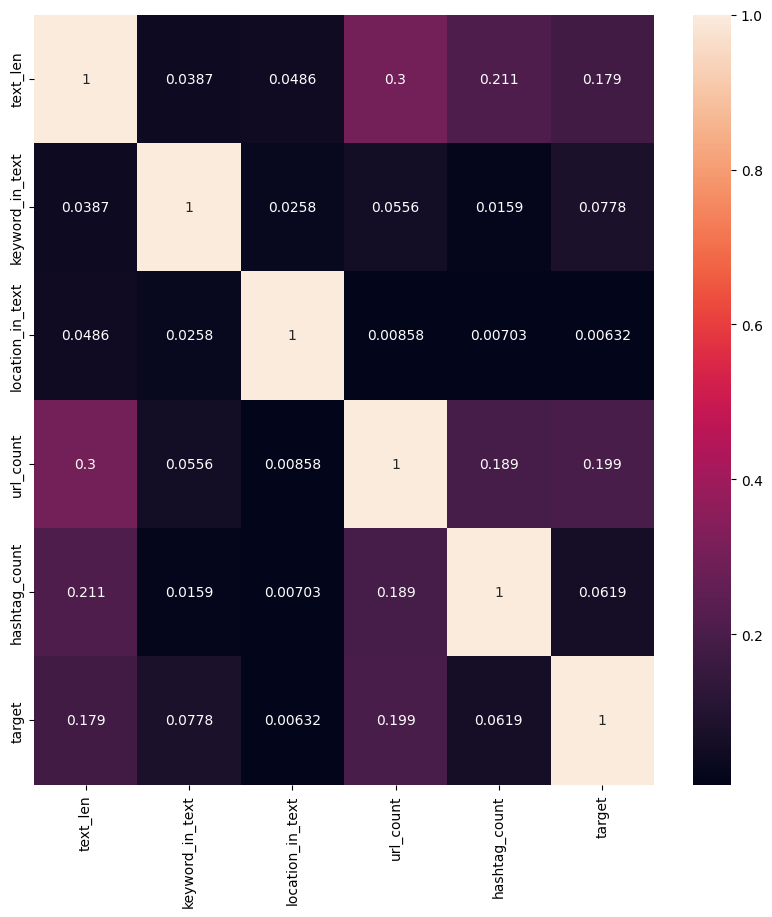

In [85]:
fig, ax = plt.subplots(figsize=(10,10)) 
cor_dfP = np.abs(df_additional.corr())
sns.heatmap(cor_dfP, annot=True, ax=ax, fmt='.3g')

In [88]:
additional = sp.csr_matrix(df_additional[['text_len', 'url_count']].values)
fine_with_additional_scores = calculate_scores(fine_truncated_vectors, fine_models, additional_vectors=additional)

94% completed. Time passed: 50. Time left: 0:00:03
text_poly_kw_loc_best_20000 Logistic Regression 800 components
Done


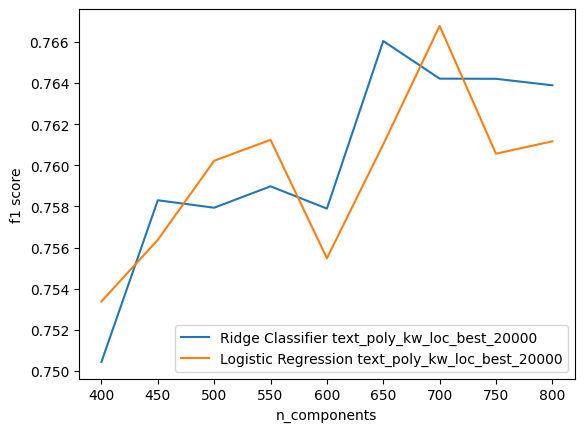

In [89]:
for model_name in fine_models:
    plot_scores([d for d in fine_with_additional_scores if d['model'] == model_name])

Additional columns do not add any value

## Fine tuning Logistic Regression

In [98]:
# model_rc = RidgeClassifier(random_state=42, max_iter=500, class_weight="balanced")

lr_models = {}
max_iter_range = range(10, 50, 10)
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
for s in solvers:
    lr_models[s] = LogisticRegression(solver=s, C=1.0, max_iter=50, random_state=42)

lr_scores = calculate_scores(fine_truncated_vectors, lr_models)

98% completed. Time passed: 150. Time left: 0:00:03
text_poly_kw_loc_best_20000 saga 800 components


/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Done


/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


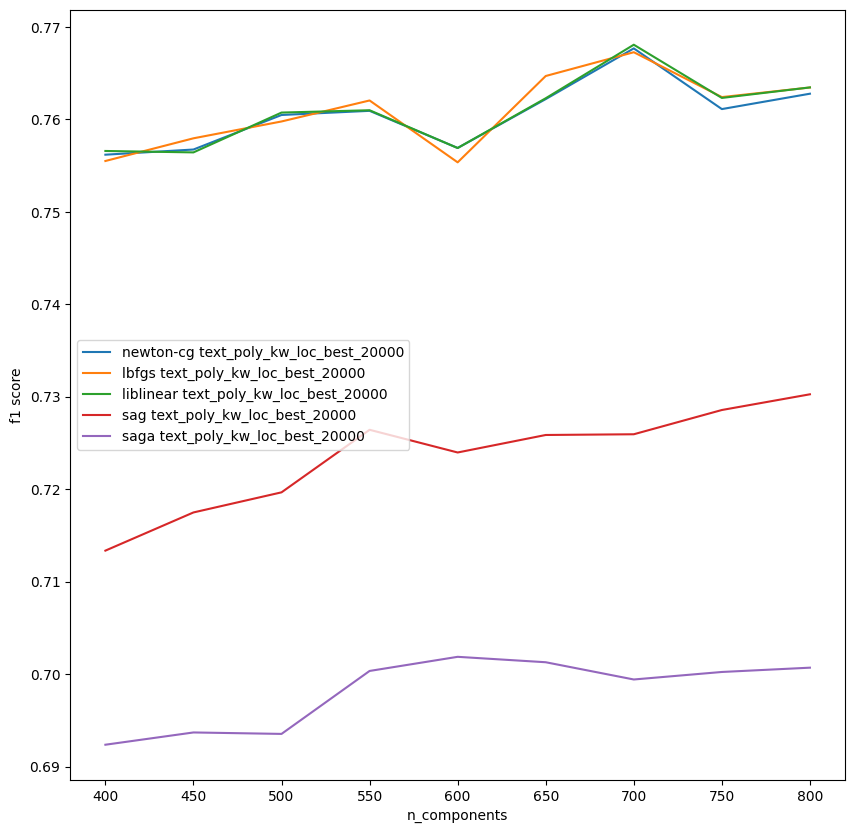

In [99]:
plt.subplots(figsize=(10,10)) 
for model_name in lr_models:
    if model_name != "Logistic Regression with 950 max iterations":
        plot_scores([d for d in lr_scores if d['model'] == model_name])

In [106]:
lr_models = {}
saga_components_range = range(700, 1001, 50)
saga_truncated_vectors = truncated_vectors(['text_poly_kw_loc_best_20000'], saga_components_range)

solvers = ['sag', 'saga']
for s in solvers:
    lr_models[s] = LogisticRegression(solver=s, C=1.0, max_iter=1000, random_state=42)

lr_scores = calculate_scores(saga_truncated_vectors, lr_models)

93% completed. Time passed: 1394. Time left: 0:01:47
text_poly_kw_loc_best_20000 saga 1000 components


/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Done


/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


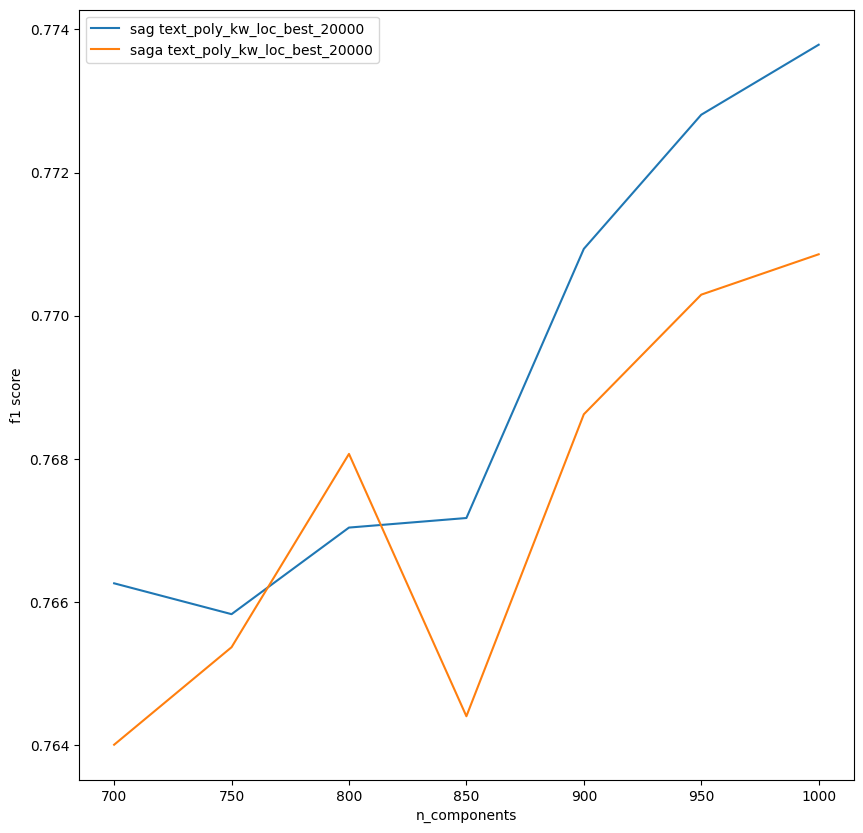

In [107]:
plt.subplots(figsize=(10,10)) 
for model_name in lr_models:
    if model_name != "Logistic Regression with 950 max iterations":
        plot_scores([d for d in lr_scores if d['model'] == model_name])

In [108]:
lr_models = {}
saga_components_range = range(1000, 1151, 50)
saga_truncated_vectors = truncated_vectors(['text_poly_kw_loc_best_20000'], saga_components_range)

solvers = ['sag']
for s in solvers:
    lr_models[s] = LogisticRegression(solver=s, C=1.0, max_iter=1000, random_state=42)

lr_scores = calculate_scores(saga_truncated_vectors, lr_models)

75% completed. Time passed: 362. Time left: 0:02:01
text_poly_kw_loc_best_20000 sag 1150 components


/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Done


/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


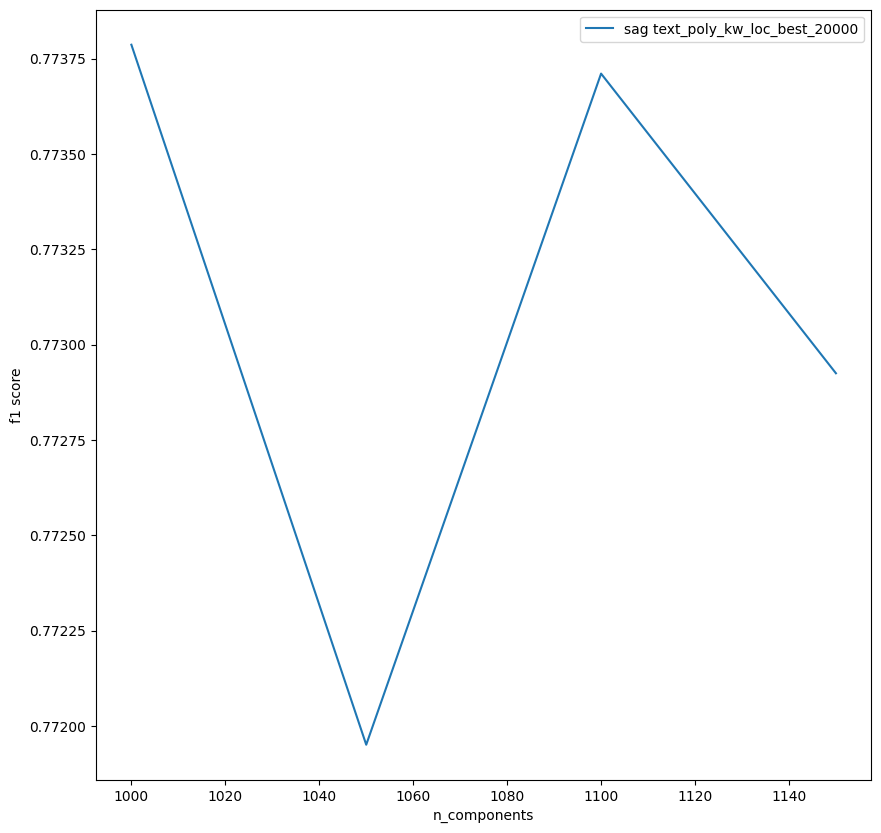

In [109]:
plt.subplots(figsize=(10,10)) 
for model_name in lr_models:
    if model_name != "Logistic Regression with 950 max iterations":
        plot_scores([d for d in lr_scores if d['model'] == model_name])

## Train and test winner models

In [144]:
def prepare_data_tkl_poly(df, k_best=20000, svd_n_components=1000):
    min_df = 30
    c_vectorizer = CountVectorizer(min_df=min_df)
    d_vectorizer = DictVectorizer()

    kw_loc_dict = df[['keyword', 'location']].to_dict(orient='records')

    kw_loc_vectors = d_vectorizer.fit_transform(kw_loc_dict)
    text_vectors = c_vectorizer.fit_transform(df.text)

    text_kw_loc_vectors = sp.hstack((text_vectors, kw_loc_vectors))
    p_features = PolynomialFeatures(2)
    text_kw_loc_poly_vectors = p_features.fit_transform(text_kw_loc_vectors)
    s_k_best = SelectKBest(chi2, k=k_best)
    best_vectors = s_k_best.fit_transform(text_kw_loc_poly_vectors, df.target)
    
    svd = TruncatedSVD(n_components=svd_n_components, n_iter=20, random_state=42)
    vectors = svd.fit_transform(best_vectors)
    
    return {
        'c_vect': c_vectorizer,
        'd_vect': d_vectorizer,
        'p_feat': p_features,
        's_k_best': s_k_best,
        'svd': svd,
        'vectors': vectors
    }

In [146]:
def prepare_test_data_tkl_poly(df, train_data):
    c_vectorizer = train_data['c_vect']
    d_vectorizer = train_data['d_vect']
    p_features = train_data['p_feat']
    s_k_best = train_data['s_k_best']
    svd = train_data['svd']
    
    kw_loc_dict = df[['keyword', 'location']].to_dict(orient='records')

    kw_loc_vectors = d_vectorizer.transform(kw_loc_dict)
    text_vectors = c_vectorizer.transform(df.text)

    text_kw_loc_vectors = sp.hstack((text_vectors, kw_loc_vectors))
   
    text_kw_loc_poly_vectors = p_features.transform(text_kw_loc_vectors)
    best_vectors = s_k_best.transform(text_kw_loc_poly_vectors)
    
    vectors = svd.transform(best_vectors)
    
    return vectors

In [158]:
%%time
train_data_sag = prepare_data_tkl_poly(df_full_train, svd_n_components=1000)
test_data_sag = prepare_test_data_tkl_poly(df_test, train_data_sag)
model_lr_sag = LogisticRegression(solver="sag", C=1.0, max_iter=1000, random_state=42)
model_lr_sag.fit(train_data_sag['vectors'], df_full_train.target)
f1_score(df_test.target, model_lr_sag.predict(test_data_sag))

CPU times: user 4min 24s, sys: 8min 53s, total: 13min 18s
Wall time: 3min 25s


/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.7266721717588769

In [155]:
%%time
train_data_rc = prepare_data_tkl_poly(df_full_train, svd_n_components=700)
test_data_rc = prepare_test_data_tkl_poly(df_test, train_data_rc)
model_rc = RidgeClassifier(random_state=42, max_iter=500, class_weight="balanced")
model_rc.fit(train_data_rc['vectors'], df_full_train.target)
f1_score(df_test.target, model_rc.predict(test_data_rc))

CPU times: user 1min 44s, sys: 57.4 s, total: 2min 42s
Wall time: 1min 11s


0.721958925750395